In [1]:
import tensorflow as tf
#from tensorflow import keras
import tensorflow.python.keras.optimizers as Opt
#from tensorflow import keras.optimizers
import tensorflow.python.keras.metrics
from tensorflow.python.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cartopy.crs as ccrs
import cartopy.feature as cf
import pickle 
from datetime import date
import xarray as xr
import netCDF4 as nc
#from u_interpolate_small import regrid_irregular_quick
import u_interpolate_small as uint
from ndays import numOfDays
import glob
import calendar
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

2024-11-30 21:37:07.387569: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-30 21:37:07.390536: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-30 21:37:07.401096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-30 21:37:07.419683: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-30 21:37:07.424944: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 21:37:07.438724: I tensorflow/core/platform/cpu_feature_gu

In [2]:
# Define domain and time period
start_lat = 9 # 5 
end_lat = 20 #10
start_lon = -18 #-10
end_lon = -7 #0
start_year = '2010'
start_month = '07'
end_year = '2010'
end_month = '08'
start_day = '01'
end_day = '31'


# find ndays
date1 = date(int(start_year), int(start_month), int(start_day))
date2 = date(int(end_year), int(end_month), int(end_day))
t = numOfDays(date1, date2)+1

# define a regular lat/lon grid close to MSG native resolution (0.04 deg)
reg_lat = np.arange(start_lat, end_lat, 0.04)
reg_lon = np.arange(start_lon, end_lon, 0.04) 



In [3]:
# get native MSG grid (core)
coords_filename= './nxny1640_580_nxnyds164580_blobdx0.04491576_area4_n23_20_32.nc'#[0]  # this is /prj/Africa_cloud/geoloc/*.npz on the Linux system
msg_file = xr.open_dataset(coords_filename).squeeze() # pick any convective core file from ch9_wavelet. 
mlon = msg_file['lons_mid'].values
mlat = msg_file['lats_mid'].values
# find core indices using one file
lat_ind = np.where((mlat[:,1]>=start_lat) & (mlat[:,1]<=end_lat))[0]
lon_ind = np.where((mlon[1,:]>=start_lon) & (mlon[1,:]<=end_lon))[0]
lat = mlat[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
lon = mlon[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
#lon = lon_fl[(lon_fl>= start_lon) & (lon_fl<=end_lon)]


In [4]:
# get lst grid
coords_filename_lst = '/prj/swift/SEVIRI_LST/Ancillary/lsasaf_PanAfrica_latlon.nc'
lst_cord_file = xr.open_dataset(coords_filename_lst).squeeze() # pick any convective core file from ch9_wavelet. 
lon_lst = lst_cord_file['longitude'].values
lat_lst = lst_cord_file['latitude'].values


In [5]:
# calculate interpolation weights from MSG (core) 
inds, weights, shape = uint.interpolation_weights(lon, lat, reg_lon, reg_lat) # save weights for continuous use - MSG interpolation on regular. 

# calculate interpolation weights for lst 
inds_lst, weights_lst, shape_lst = uint.interpolation_weights(lon_lst, lat_lst, reg_lon, reg_lat) # save for continuous use - IMERG interpolation weights to same grid. 


In [6]:
cores = np.zeros((t*96,len(lat[:,1]),len(lon[1,:])),dtype=float) 
tir = np.zeros((t*96,len(lat[:,1]),len(lon[1,:])),dtype=float) 
time_core = np.zeros((t*96)) 
#lst = np.zeros((t*96,len(lat_lst[:,1]),len(lon_lst[1,:])),dtype=float) 

regridded_cores = np.zeros((t*96,len(reg_lat),len(reg_lon)),dtype=float) 
regridded_tir = np.zeros((t*96,len(reg_lat),len(reg_lon)),dtype=float) 
regridded_lst = np.zeros((t*96,len(reg_lat),len(reg_lon)),dtype=float) 
regridded_lst_mask = np.zeros((t*96,len(reg_lat),len(reg_lon)),dtype=float) 


In [7]:
# read in cores data
list_of_file_names = []

if int(start_year)==int(end_year): 
    for m in range(int(start_month),int(end_month)+1,1): # 1 to include the end month
        if m<10:
            month = str(m).zfill(2)
        else:
            month = str(m)  
        for d in range(1,calendar.monthrange(int(start_year), m)[1]+1,1): # 1 to include the end month
            if d<10:
                day = str(d).zfill(2)
            else:
                day = str(d)  
            #core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
            dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
            all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*.nc"));
            list_of_file_names.append(all_file_names) # all days in month
               
elif int(start_year)<int(end_year):
    y=1
    for i in range(int(start_year),int(end_year)+1,1):
        if y==1:
            for m in range(int(start_month),10,1):
                if m<10:
                    month = str(m).zfill(2)
                else:
                    month = str(m)  
                for d in range(1,calendar.monthrange(i, m)[1]+1,1):
                #for d in range(1,30,1): # 1 to include the end month
                    if d<10:
                        day = str(d).zfill(2)
                    else:
                        day = str(d)  
            #core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
                    dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
                    all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*.nc"));
                    list_of_file_names.append(all_file_names) # all days in month
            #print((all_file_names))
                #print(len(all_file_names))
                y=y+1
                month=[]
            
        else:
            for m in range(1,int(end_month)+1,1):
                if m<10:
                    month = str(m).zfill(2)
                else:
                    month = str(m)    
                for d in range(1,calendar.monthrange(i, m)[1]+1,1):
                    if d<10:
                        day = str(d).zfill(2)
                    else:
                        day = str(d)  
                    dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
                    all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*.nc"));
                    list_of_file_names.append(all_file_names) # all days in month
                  
list_of_files=[]                
for a in range(0,len(list_of_file_names),1):
    list_of_files = list_of_files+list_of_file_names[a]
#if int(start_year)<int(end_year):
 #   list_of_files = list_of_files[0]+list_of_files[1]
#else:
   # list_of_files = list_of_files[0]#+list_of_files[1]    
print(len(list_of_files))

5952


In [8]:
for l in range(0,len(list_of_files),1):#, min(t*96,len(list_of_files)), 4):#range(len(list_of_files)): # 96 files per day
    core_filename = list_of_files[l]#'/prj/Africa_cloud/ch9_wavelet/'+str(i)+'/'+month+'/'  list_of_files[l]
    print(core_filename)
    #if os.path.isfile(all_file_names):      
    ds = xr.open_dataset(core_filename).squeeze() 
    print(l)
    core_temp = ds['msg_cores'].values
    cores[l,:,:] = core_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
    regridded_cores[l,:,:] = uint.interpolate_data(cores[l,:,:], inds, weights, shape)  # interpolation using saved weights for MSG TIR

    #uint.interpolate_data(ds['cores'].values, inds, weights, shape) # interpolation using saved weights for MSG cores       
    tir_temp =  ds['msg_Tir'].values/10000
    tir[l,:,:] = tir_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]    
    regridded_tir[l,:,:] = uint.interpolate_data(tir[l,:,:], inds, weights, shape)  # interpolation using saved weights for MSG TIR
    
    time_core[l] = int(core_filename[-15:-3])


/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010000.nc
0
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010015.nc
1
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010030.nc
2
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010045.nc
3
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010100.nc
4
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010115.nc
5
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010130.nc
6
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010145.nc
7
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010200.nc
8
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010215.nc
9
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010230.nc
10
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010245.nc
11
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010300.nc
12
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010315.nc
13
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010330.nc
14
/prj/

In [9]:
# read in LST data
list_of_file_names = []
lst_dir= '/prj/swift/SEVIRI_LST/SEVIRI_LST_2004-2022/SEVIRI_daily_mean/'

for i in range(0,len(time_core),1):
    current_file = str(time_core[i])    #+'.nc'
    SY= current_file[0:4]
    MM= current_file[4:6]
    DD= current_file[6:8]
    #previous_date = get_previous_date(SY+'-'+MM+'-'+DD)  
    #print(previous_date)
#    all_file_names = lst_dir+previous_date[0:4]+previous_date[5:7]+'/LSASAF_lst_anom_Daymean_withmask_withHistClim_'+previous_date[0:4]+previous_date[5:7]+previous_date[8:]+'_1700'+'.nc' 
    all_file_names = lst_dir+SY+MM+'/LSASAF_lst_anom_Daymean_withmask_withHistClim_'+SY+MM+DD+'_1700'+'.nc' 
    #print(all_file_names)
    if os.path.isfile(all_file_names):      
        list_of_file_names.append(all_file_names) # all days in month
    else:
        list_of_file_names.append('file_not_available') # all days in month
 

In [10]:
num_of_missing_lst_files = 0

for l in range(0,len(list_of_file_names),1):   
    lst_filename = list_of_file_names[l]   
    print(lst_filename)
    if os.path.isfile(lst_filename):      
        lst_file = xr.open_dataset(lst_filename).squeeze() # 
        lst_anom = lst_file['lst_anom_dailymean'].values
        lst_anom_mask=lst_anom*0+1
        lst_anom_mask[np.isnan(lst_anom)]=0       
        lst_anom[np.isnan(lst_anom)]=0
        print(l)    
      #  lst[l,:,:] = lst_anom[lat_lst_ind[0]:lat_lst_ind[-1]+1,lon_lst_ind[0]:lon_lst_ind[-1]+1]
        regridded_lst[l,:,:] = uint.interpolate_data(lst_anom, inds_lst, weights_lst, shape_lst)  # interpolation using saved weights for MSG TIR
        regridded_lst_mask[l,:,:] = uint.interpolate_data(lst_anom_mask, inds_lst, weights_lst, shape_lst)  # interpolation using saved weights for MSG TIR
        
    else:
        num_of_missing_lst_files = num_of_missing_lst_files +1
       # hist_cores[l,:,:] = hist_cores_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
     
regridded_lst_mask[np.where(regridded_lst_mask<0.9)]=0
regridded_lst_mask[np.where(regridded_lst_mask>=0.9)]=1
        

/prj/swift/SEVIRI_LST/SEVIRI_LST_2004-2022/SEVIRI_daily_mean/201007/LSASAF_lst_anom_Daymean_withmask_withHistClim_20100701_1700.nc
0
/prj/swift/SEVIRI_LST/SEVIRI_LST_2004-2022/SEVIRI_daily_mean/201007/LSASAF_lst_anom_Daymean_withmask_withHistClim_20100701_1700.nc
1
/prj/swift/SEVIRI_LST/SEVIRI_LST_2004-2022/SEVIRI_daily_mean/201007/LSASAF_lst_anom_Daymean_withmask_withHistClim_20100701_1700.nc
2
/prj/swift/SEVIRI_LST/SEVIRI_LST_2004-2022/SEVIRI_daily_mean/201007/LSASAF_lst_anom_Daymean_withmask_withHistClim_20100701_1700.nc
3
/prj/swift/SEVIRI_LST/SEVIRI_LST_2004-2022/SEVIRI_daily_mean/201007/LSASAF_lst_anom_Daymean_withmask_withHistClim_20100701_1700.nc
4
/prj/swift/SEVIRI_LST/SEVIRI_LST_2004-2022/SEVIRI_daily_mean/201007/LSASAF_lst_anom_Daymean_withmask_withHistClim_20100701_1700.nc
5
/prj/swift/SEVIRI_LST/SEVIRI_LST_2004-2022/SEVIRI_daily_mean/201007/LSASAF_lst_anom_Daymean_withmask_withHistClim_20100701_1700.nc
6
/prj/swift/SEVIRI_LST/SEVIRI_LST_2004-2022/SEVIRI_daily_mean/201007/L

In [22]:
## a clean way of plotting - use matplotlib functions directly:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
def draw_map(ax, data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):

    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)

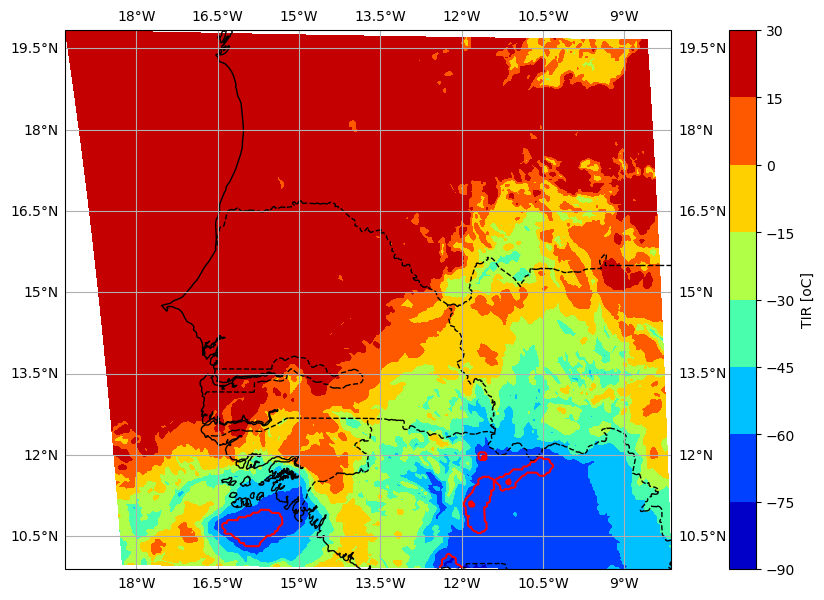

In [12]:
day = 1
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, tir[day,:,:], lon, lat,  cbar_label='TIR [oC]', cmap='jet')
# ax.contour(lon, lat, cores[day,:,:], levels=[-5,1,50], colors='r')
ax.contour(lon, lat, cores[day,:,:], colors='r')

#

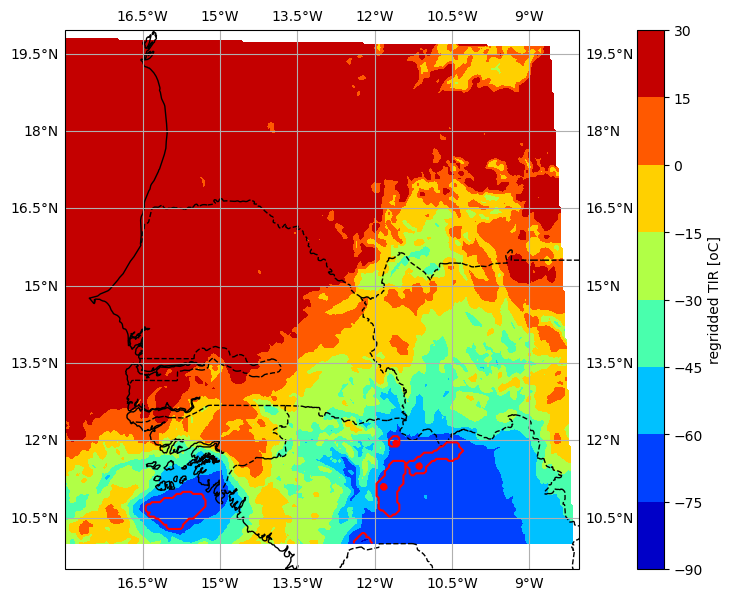

In [13]:
day = 1
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, regridded_tir[day,:,:], reg_lon, reg_lat,  cbar_label='regridded TIR [oC]', cmap='jet')
# ax.contour(lon, lat, cores[day,:,:], levels=[-5,1,50], colors='r')
ax.contour(reg_lon, reg_lat, regridded_cores[day,:,:], colors='r')


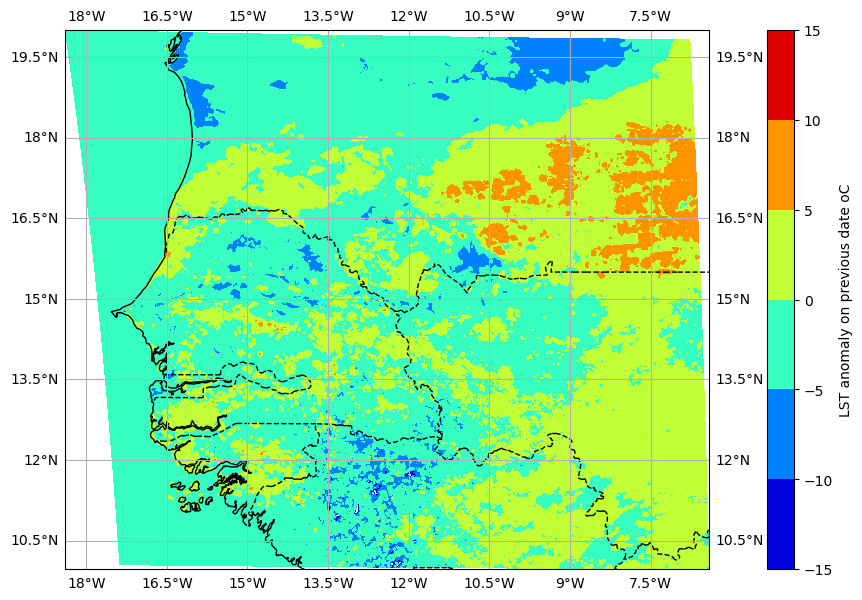

In [14]:
day = 1
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, lst_anom[592:936,100:486], lon_lst[592:936,100:486], lat_lst[592:936,100:486],levels=[-15,-10,-5,0,5,10,15], cbar_label='LST anomaly on previous date ''oC''', cmap='jet')


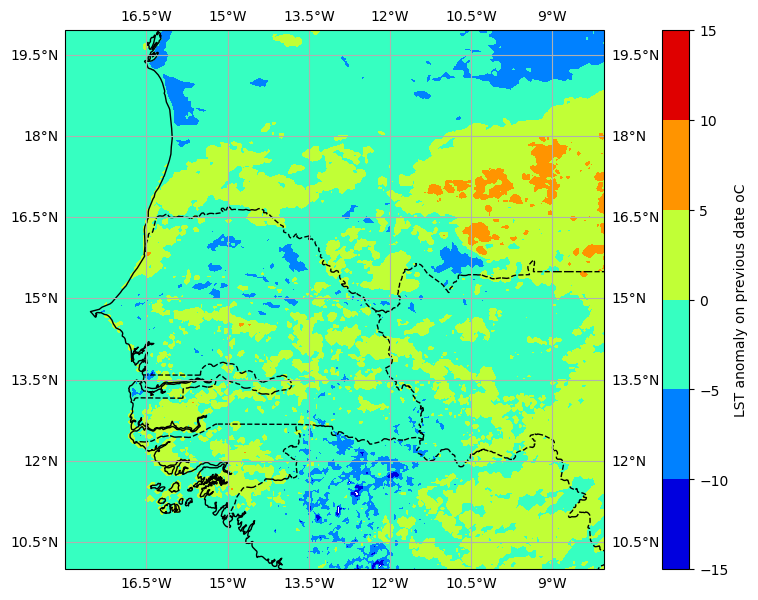

In [15]:
day = 1
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, regridded_lst[-1,:,:], reg_lon, reg_lat,levels=[-15,-10,-5,0,5,10,15], cbar_label='LST anomaly on previous date ''oC''', cmap='jet')


In [16]:
print(cores.shape)


(5952, 341, 354)


In [6]:
# save variables 
#with open('../pkl_files/WA_subdomain_cores_15min_Jul_Aug.pkl', 'wb') as file: 
 #         pickle.dump([cores, tir, time_core], file) 
        #

In [5]:
# open a file, where you stored the pickled data
# open a file, where you stored the pickled data
with open('../pkl_files/WA_lst_cores_15min_Jul_Aug_LST.pkl', 'rb') as file: 
    data = pickle.load(file)
    regridded_cores= data[0]
    regridded_tir= data[1]
   # regridded_lst= data[2]
    time_core= data[3]
    
with open('../pkl_files/WA_lst_cores_15min_Jul_Aug_LST_mask.pkl', 'rb') as file: 
    data = pickle.load(file)
    regridded_lst= data[0]
    regridded_lst_mask= data[1]
 


In [6]:
regridded_cores.shape

(5952, 275, 275)

In [7]:
# input data- cores_t_0: 
# starting at 
num_frames= 3   # previous 2 hours of images to predict 1 hr later
t0= 1  #1   30 min  later (4 frames at 15 min)
a= 19
b= 19

# cores
ind = np.where(regridded_cores>0)
regridded_cores[ind] = 1
regridded_cores[np.isnan(regridded_cores)] = 0
cores_t_0 = regridded_cores[0:(-num_frames-t0), :-a,b:]

# norm TIR
tir_t_0 = regridded_tir[0:(-num_frames-t0), :-a,b:]
ind_tir = np.where(tir_t_0>-0.01)
tir_t_0[ind_tir] = 0
tir_t_0[np.isnan(tir_t_0)] = 0
tir_t_0 = tir_t_0/np.min(tir_t_0)

# lsta and lsta mask
lst_t_0 = regridded_lst[0:(-num_frames-t0),:-a,b:]
lst_t_0[np.isnan(lst_t_0)]=0
lst_t_0 = lst_t_0/np.max(np.absolute(lst_t_0))
#ind_nan = np.isnan(regridded_lst[0:(-num_frames-t0),:-a,b:])
lst_no_data = regridded_lst_mask[0:(-num_frames-t0),:-a,b:]
lst_no_data[np.isnan(lst_no_data)] = 0

# target data
cores_t_plus_xhr = regridded_cores[(t0+num_frames):,:-a,b:]
prediction_time = time_core[(t0+num_frames):]


In [8]:
np.min(tir_t_0)

-0.0

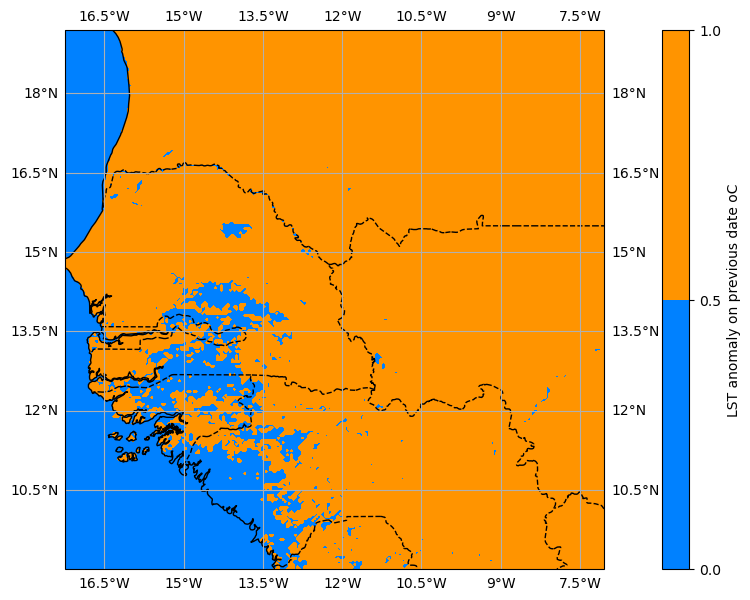

In [11]:
#lst_t_0 = regridded_lst[0:(-num_frames-t0)*4,:-a,b:]
day = 1
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
#draw_map(ax, lst_no_data_temp, reg_lon[b:], reg_lat[:-a],levels=[0,0.5,1], cbar_label='LST anomaly on previous date ''oC''', cmap='jet')
draw_map(ax, lst_no_data[-1,:,:], reg_lon[b:], reg_lat[:-a],levels=[0,0.5,1], cbar_label='LST anomaly on previous date ''oC''', cmap='jet')
#draw_map(ax, lst_t_0[-1,:,:], reg_lon[b:], reg_lat[:-a],levels=np.arange(-1,1,0.1), cbar_label='LST anomaly on previous date ''oC''', cmap='jet')
#draw_map(ax, regridded_lst[-1,:-a,b:], reg_lon[b:], reg_lat[:-a],levels=[-15,-10,-5,0,5,10,15], cbar_label='LST anomaly on previous date ''oC''', cmap='jet')



In [12]:
print(cores_t_0.shape)
print(tir_t_0.shape)
print(lst_t_0.shape)
print(lst_no_data.shape)
print(cores_t_plus_xhr.shape)


(5948, 256, 256)
(5948, 256, 256)
(5948, 256, 256)
(5948, 256, 256)
(5948, 256, 256)


In [8]:
# training data
tir_t_0_minus_2 = tir_t_0[0:-2*4]
tir_t_0_minus_1 = tir_t_0[1*4:-1*4]
tir_t_0 = tir_t_0[2*4:]
lst_t_0 = lst_t_0[2*4:]
lst_no_data = lst_no_data[2*4:]

cores_t_plus_xhr = cores_t_plus_xhr[2*4:]
prediction_time = prediction_time[2*4:]


In [14]:
print(tir_t_0_minus_2.shape)
print(tir_t_0_minus_1.shape)
print(tir_t_0.shape)
print(lst_t_0.shape)
print(lst_no_data.shape)
print(cores_t_plus_xhr.shape)
print(prediction_time.shape)



(5940, 256, 256)
(5940, 256, 256)
(5940, 256, 256)
(5940, 256, 256)
(5940, 256, 256)
(5940, 256, 256)
(5940,)


In [9]:
# Define input shape
#num_frames= 24  # 6 hours
image_height= len(cores_t_plus_xhr[1,:,1]) #lat
image_width= len(cores_t_plus_xhr[1,1,:]) #lon
num_channels= 5 #  core at t0-, core at t0-1,  



In [10]:
total_samples= int(tir_t_0.shape[0])
x_train= np.zeros((total_samples,image_height,image_width, num_channels))

x_train[:,:,:,0]= tir_t_0_minus_2
x_train[:,:,:,1]= tir_t_0_minus_1
x_train[:,:,:,2]= tir_t_0
x_train[:,:,:,3]= lst_t_0
x_train[:,:,:,4]= lst_no_data
y_train= cores_t_plus_xhr

x_tr, x_test, y_tr, y_test, time_tr, time_test = train_test_split(x_train,y_train,prediction_time, test_size=0.3,random_state=42)

del x_train

In [13]:
print(x_tr.shape)
print(x_test.shape)
print(y_test.shape)
print(time_tr.shape)
print(time_test.shape)


(4158, 256, 256, 5)
(1782, 256, 256, 5)
(1782, 256, 256)
(4158,)
(1782,)


In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D)
from tensorflow.keras import layers

# define conv layer
def conv_layer(x_in, filters, gn_num, strides = 1, shape = (image_height,image_width), name=None):
    x = Conv2D(filters, 5, strides=strides, padding='same')(x_in)
    x = Activation('relu', name = name)(x)
   ## x = layers.BatchNormalization()(x)
    #x = tfa.layers.GroupNormalization(groups=gn_num, axis=3)(x) # could replace this with BatchNorm
    return x

In [15]:
# def basic unet structure
def unet_basic(input_shape=(image_height, image_width, num_channels), meta_input_shape=(image_height, image_width,1) ,chan_num=num_channels):

    inputs = Input(shape=input_shape)    # 256 x 256 x 2
    meta_inputs = Input(shape=meta_input_shape)

    # downsample
    down2 = conv_layer(inputs, 4, 1)     # 256 x 256 x 4
    down2_pool = MaxPooling2D((2, 2), strides=None)(down2)   # 128 x 128 x 4

    down3 = conv_layer(down2_pool, 8, None) # 128 x 128 x 8
    down3_pool = MaxPooling2D((4, 4), strides=None)(down3) # 32 x 32 x 8
    #print(down3_pool.shape)
 
    center = conv_layer(down3_pool, 16, None) # 32 x 32 x 16
    center = conv_layer(center, 8, None) # 32 x 32 x 8
  
    up3 = UpSampling2D((4, 4))(center) # 128 x 128 x 8
    up3 = concatenate([down3, up3], axis=3) # 128 x 128 x 16
    up3 = conv_layer(up3, 4, None) # 128 x 128 x 4

    up2 = UpSampling2D((2, 2))(up3) # 256 x 256 x 4
    up2 = concatenate([down2, up2, meta_inputs], axis=3) # 256 x 256 x 9
#    up2 = concatenate([down2, up2], axis=3) # 256 x 256 x 8
    up2 = conv_layer(up2, 4, None) # 256 x 256 x 4
  
    # predict
    output = Conv2D(1, (1, 1))(up2)
#    time_conv = layers.concatenate([output, meta_inputs]) # 256x256x2
    #time_conv = layers.concatenate([up2, meta_inputs]) # 256x256x2
  #  output1 = conv_layer(time_conv, 1, None) # 256 x 256 x 1
#    output2 = layers.Activation('sigmoid', dtype='float32', name='prob_pred')(output1)
    output1 = layers.Activation('sigmoid', dtype='float32', name='prob_pred')(output)
    
    # create model object
    unet = Model(inputs=[inputs,meta_inputs], outputs=output1, name = 'prob_map_unet')
    return unet




In [16]:
# build model - error here
unet_model = unet_basic(input_shape=(image_height, image_width, num_channels),meta_input_shape=(image_height, image_width,1), chan_num=num_channels)



In [17]:
unet_model.summary()

Model: "prob_map_unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        504 │ input_layer[0][0] │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │        808 │ max_pooling2d[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32, 8) │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      3,216 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32, 8) │      3,208 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32, 8) │          0 │ conv2d_3[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 128, 128,  │          0 │ activation_3[0][… │
│ (UpSampling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (Concatenate)       │ 16)               │            │ up_sampling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │      1,604 │ concatenate[0][0] │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128, 128,  │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 256, 256,  │          0 │ activation_4[0][… │
│ (UpSampling2D)      │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                 

 Total params: 10,249 (40.04 KB)

 Trainable params: 10,249 (40.04 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
def _create_mean_filter(half_num_rows, half_num_columns, num_channels):
    """Creates convolutional filter that computes mean.

    M = number of rows in filter
    N = number of columns in filter
    C = number of channels

    :param half_num_rows: Number of rows on either side of center.  This is
        (M - 1) / 2.
    :param half_num_columns: Number of columns on either side of center.  This
        is (N - 1) / 2.
    :param num_channels: Number of channels.
    :return: weight_matrix: M-by-N-by-C-by-C numpy array of filter weights.
    """

    num_rows = 2 * half_num_rows + 1
    num_columns = 2 * half_num_columns + 1
    weight = 1. / (num_rows * num_columns)

    return np.full(
        (num_rows, num_columns, num_channels, num_channels), weight,
        dtype=np.float32
    )


In [12]:
def FSS_loss(target_tensor, prediction_tensor):
    
    half_window_size_px=7
    use_as_loss_function=True 
    #mask_matrix
    function_name=None
    test_mode=False
    """Fractions skill score (FSS).

    M = number of rows in grid
    N = number of columns in grid

    :param half_window_size_px: Number of pixels (grid cells) in half of
        smoothing window (on either side of center).  If this argument is K, the
        window size will be (1 + 2 * K) by (1 + 2 * K).
    :param use_as_loss_function: Boolean flag.  FSS is positively oriented
        (higher is better), but if using it as loss function, we want it to be
        negatively oriented.  Thus, if `use_as_loss_function == True`, will
        return 1 - FSS.  If `use_as_loss_function == False`, will return just
        FSS.
    :param mask_matrix: M-by-N numpy array of Boolean flags.  Grid cells marked
        "False" are masked out and not used to compute the loss.
    :param function_name: Function name (string).
    :param test_mode: Leave this alone.
    :return: loss: Loss function (defined below).
    """

    weight_matrix = _create_mean_filter(
        half_num_rows=half_window_size_px,
        half_num_columns=half_window_size_px, num_channels=1
    )
       
    #print(target_tensor.shape)
    #print(prediction_tensor.shape)
    #print(weight_matrix.shape)
        
    """Computes loss (fractions skill score).

        :param target_tensor: Tensor of target (actual) values.
        :param prediction_tensor: Tensor of predicted values.
        :return: loss: Fractions skill score.
    """

    smoothed_target_tensor = K.conv2d(
        x=target_tensor, kernel=weight_matrix,
        padding='same', strides=(1, 1), data_format='channels_last'
    )

    smoothed_prediction_tensor = K.conv2d(
        x=prediction_tensor, kernel=weight_matrix,
        padding='same', strides=(1, 1), data_format='channels_last'
    )

    #smoothed_target_tensor = smoothed_target_tensor * eroded_mask_matrix
    #smoothed_prediction_tensor = smoothed_prediction_tensor * eroded_mask_matrix)

    actual_mse = K.mean(
        (smoothed_target_tensor - smoothed_prediction_tensor) ** 2
    )
    reference_mse = K.mean(
        smoothed_target_tensor ** 2 + smoothed_prediction_tensor ** 2
    )

    if use_as_loss_function:
        return actual_mse / reference_mse

    return 1. - actual_mse / reference_mse

    if function_name is not None:
        loss.__name__ = function_name



In [20]:
# compile model
unet_model.compile(optimizer='adam',
                  loss=FSS_loss,
                  metrics=[tf.keras.metrics.Accuracy()])


In [21]:
print(x_tr.shape)
print(y_tr.shape)


(4158, 256, 256, 5)
(4158, 256, 256)


In [13]:
import math
time_of_day_tr= np.zeros((time_tr.shape[0],256,256,1))

for i in range(0,len(time_tr)):
    print(time_tr[i])
#    time_of_day = "{0:.2g}".format(float(str(time_tr[i])[-6:])/2345)
    time_of_day = float(str(time_tr[i])[-6:])/2345
    time_of_day_tr[i,:,:,:]=round(np.sin(time_of_day*math.pi),2)
    print(time_of_day_tr[i,0,0,0])
    #break
               

201007160215.0
0.28
201007042230.0
0.15
201007210100.0
0.13
201008272015.0
0.43
201007050730.0
0.83
201008172345.0
0.0
201008061800.0
0.67
201007110015.0
0.02
201008211015.0
0.98
201007010745.0
0.84
201007031215.0
1.0
201008130615.0
0.73
201007080200.0
0.26
201007030930.0
0.95
201008211800.0
0.67
201008110330.0
0.43
201007230445.0
0.56
201008131945.0
0.51
201008150830.0
0.9
201007070515.0
0.64
201008190015.0
0.02
201008010130.0
0.17
201008100030.0
0.04
201008051515.0
0.9
201008021045.0
0.99
201007090515.0
0.64
201008142300.0
0.06
201007111730.0
0.73
201007172030.0
0.41
201007261730.0
0.73
201007291915.0
0.54
201008050230.0
0.3
201008190130.0
0.17
201007161545.0
0.88
201008311830.0
0.64
201007231130.0
1.0
201008290100.0
0.13
201008031145.0
1.0
201008160845.0
0.91
201007301215.0
1.0
201007171715.0
0.75
201007061215.0
1.0
201007041115.0
1.0
201008070445.0
0.56
201007290100.0
0.13
201008112315.0
0.04
201008071745.0
0.72
201007030915.0
0.94
201008161630.0
0.82
201008100200.0
0.26
2010070421

In [23]:
print(x_tr.shape)
print(time_of_day_tr.shape)

(4158, 256, 256, 5)
(4158, 256, 256, 1)


In [14]:
from tensorflow.python.keras.engine import data_adapter

def _is_distributed_dataset(ds):
    return isinstance(ds, data_adapter.input_lib.DistributedDatasetSpec)

data_adapter._is_distributed_dataset = _is_distributed_dataset

tf.config.run_functions_eagerly(True)

In [25]:
# Define modifiable training hyperparameters.
epochs =  20
batch_size = 4 #50# batch_size#24
y_tr=tf.expand_dims(y_tr, axis=3)
#time_meta_input= 

# Fit the model to the training data.
model_history = unet_model.fit([x_tr,time_of_day_tr],
                               y_tr,
                               batch_size=batch_size,
                               epochs=epochs,
                               validation_split = 0.1)
#    callbacks=[early_stopping, reduce_lr],


/home/jawahm/miniforge3/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 1059s 1s/step - accuracy: 0.0000e+00 - loss: 0.5261 - val_accuracy: 0.0000e+00 - val_loss: 0.3668
Epoch 2/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 1036s 1s/step - accuracy: 0.0000e+00 - loss: 0.3544 - val_accuracy: 0.0000e+00 - val_loss: 0.3106
Epoch 3/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 1050s 1s/step - accuracy: 0.0000e+00 - loss: 0.3202 - val_accuracy: 0.0000e+00 - val_loss: 0.3059
Epoch 4/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 1042s 1s/step - accuracy: 0.0000e+00 - loss: 0.2900 - val_accuracy: 0.0000e+00 - val_loss: 0.3072
Epoch 5/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 1042s 1s/step - accuracy: 0.0000e+00 - loss: 0.2782 - val_accuracy: 0.0000e+00 - val_loss: 0.2913
Epoch 6/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 1066s 1s/step - accuracy: 0.0000e+00 - loss: 0.2705 - val_accuracy: 0.0000e+00 - val_loss: 0.3303
Epoch 7/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 1011s 1s/step - accuracy: 0.0000e+00 - loss: 0.2619 - val_accuracy: 0.0000e+00 - val_loss: 0.2846
Epoch 8/20
936/936 ━━━━━━━━━━━━━━━

In [15]:
#with open('../pkl_files/WA_Jul_Aug_trained_model_3channel_4hr_using_1hr_TIR_time_of_day_32x32.pkl', 'wb') as file: 
 #   pickle.dump(unet_model, file) 

#unet_model.save('../pkl_files/WA_Jul_Aug_trained_model_3channel_1hr_using_1hr_TIR_time_of_day_end_LST.h5')


modelFile='../pkl_files/WA_Jul_Aug_trained_model_3channel_1hr_using_1hr_TIR_time_of_day_end_LST.h5'
unet_model = tf.keras.models.load_model(modelFile, compile=False,custom_objects={'loss': FSS_loss})


In [16]:
time_of_day_test= np.zeros((time_test.shape[0],256,256,1))

for i in range(0,len(time_test)):
    print(time_test[i])
    time_of_day = float(str(time_test[i])[-6:])/2345
    time_of_day_test[i,:,:,:]=round(np.sin(time_of_day*math.pi),2)
    #time_of_day_test[i,:,:,:]=time_of_day
#    time_of_day = float(str("{:,.2f}".format(time_tr[i])[-6:]))
    print(time_of_day_test[i,0,0,0])
    #break
    

201008301145.0
1.0
201008190500.0
0.62
201007271445.0
0.93
201008191445.0
0.93
201007222045.0
0.39
201007250900.0
0.93
201008290245.0
0.32
201008051930.0
0.53
201008201045.0
0.99
201007230645.0
0.76
201008032230.0
0.15
201008051730.0
0.73
201007191330.0
0.98
201007131600.0
0.84
201007160200.0
0.26
201007201415.0
0.95
201008031600.0
0.84
201007311230.0
1.0
201007191415.0
0.95
201008312245.0
0.13
201008180930.0
0.95
201007231600.0
0.84
201008222000.0
0.45
201007200500.0
0.62
201008260700.0
0.81
201008120200.0
0.26
201007222245.0
0.13
201007080515.0
0.64
201008200030.0
0.04
201007031315.0
0.98
201007021815.0
0.65
201007061630.0
0.82
201007090145.0
0.19
201007292215.0
0.17
201007120745.0
0.84
201008191800.0
0.67
201008171830.0
0.64
201007031445.0
0.93
201008020345.0
0.45
201008092015.0
0.43
201007222345.0
0.0
201007141245.0
1.0
201008050830.0
0.9
201008061830.0
0.64
201008281130.0
1.0
201007201900.0
0.56
201007250615.0
0.73
201007111200.0
1.0
201008171400.0
0.95
201007160630.0
0.75
2010082

In [17]:
# example date = 201008121545.0
#ind = np.where(np.logical_and(time_test>= 201008121000, time_test<= 201008121900)) 
ind = np.where(np.logical_and(time_test>= 201008121400, time_test<= 201008121700)) 
#for b in range(0,51,1):
batch_number = ind[0][0] # 20 # 0,1
frames = x_test[batch_number,:,:,:] # 
original_frame = y_test[batch_number,:,:] # 
print(frames.shape)
time_of_test = time_of_day_test[batch_number, :,:,:]
print(time_of_test.shape)

# Extract the model's prediction and post-process it.
predicted_frame = unet_model.predict([np.expand_dims(frames, axis=0),np.expand_dims(time_of_test, axis=0)])



(256, 256, 5)
(256, 256, 1)


/home/jawahm/miniforge3/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


In [18]:
print(predicted_frame.shape)
#print(np.unique(predicted_frame))

(1, 256, 256, 1)


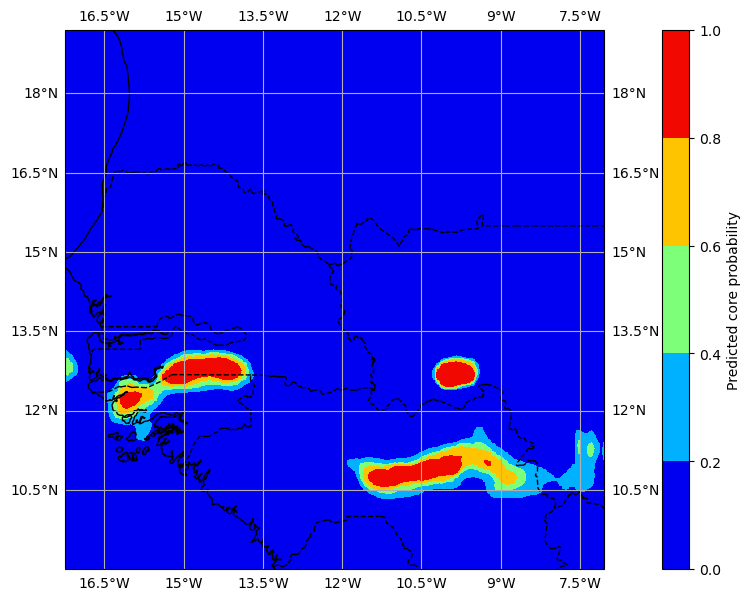

In [64]:
t0= 0#1   #*4 # # 15 min  later (4 frames at 15 min)
a= 19
b= 19

f=plt.figure(figsize=(15,7)) 
ax = f.add_subplot(111, projection=ccrs.PlateCarree()) 
draw_map(ax, np.squeeze(predicted_frame[0,:,:,0]), reg_lon[b:], reg_lat[:-a],levels=[0, 0.2, 0.4, 0.6, 0.8,1], cbar_label='Predicted core probability', cmap='jet')

#np.

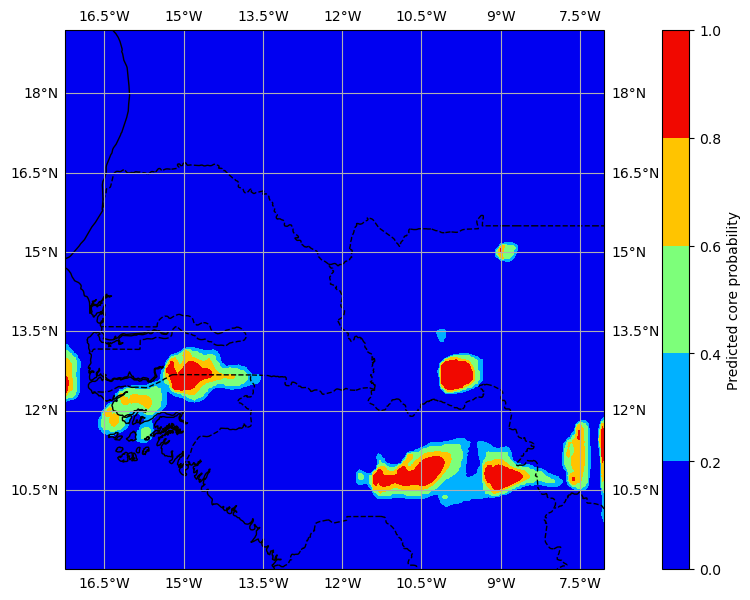

In [31]:
t0= 0#1   #*4 # # 15 min  later (4 frames at 15 min)
a= 19
b= 19

f=plt.figure(figsize=(15,7)) 
ax = f.add_subplot(111, projection=ccrs.PlateCarree()) 
draw_map(ax, np.squeeze(predicted_frame[0,:,:,0]), reg_lon[b:], reg_lat[:-a],levels=[0, 0.2, 0.4, 0.6, 0.8,1], cbar_label='Predicted core probability', cmap='jet')


In [19]:
def plot_maps(ax, lon, lat, data, title,levels_custom):
    m=ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), levels=levels_custom,cmap='jet')  # this is the actual plot
    ax.coastlines()   ## adds coastlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    #cbar = plt.colorbar(m)  # adds colorbar
    #cbar.set_label('core')

In [20]:
def plot_maps_colorbar(ax, lon, lat, data, title,levels_custom,clabel,cmap):
    m=ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), levels=levels_custom,cmap=cmap)  # this is the actual plot
    ax.coastlines()   ## adds coastlines
    xl = ax.gridlines(draw_labels=False);   # adds latlon grid lines
    xl.xlabels_bottom = True   ## labels off
    xl.ylabels_left = True
    ax.set_title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(m)  # adds colorbar
    cbar.set_label(clabel)

201008121600.0


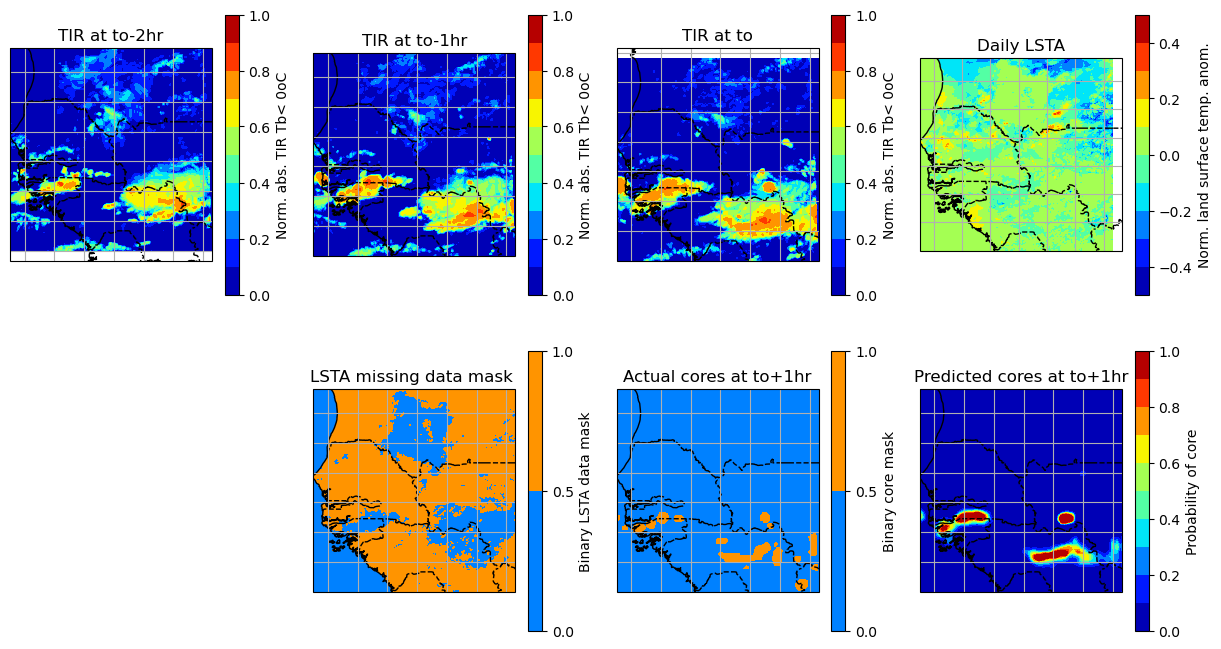

In [23]:
data = np.zeros((7,image_height,image_width))
data[0] = np.squeeze(frames[:,:,0])
data[1] = np.squeeze(frames[:,:,1])
data[2] = np.squeeze(frames[:,:,2])
data[3] = np.squeeze(frames[:,:,3])
data[4] = np.squeeze(frames[:,:,4])
data[5] = np.squeeze(original_frame[:,:])
data[6] = np.squeeze(predicted_frame[0,:,:,0])
titles = ['TIR at to-2hr','TIR at to-1hr','TIR at to','Daily LSTA','LSTA missing data mask ','Actual cores at to+1hr', 'Predicted cores at to+1hr']
levels_custom=[[0, 0.2, 0.4, 0.6, 0.8,1],[0, 0.5, 1],np.arange(0,1.05,0.1),np.arange(-0.5,0.55,0.1)]
labels=['Norm. abs. TIR Tb< 0oC','Norm. land surface temp. anom.','Binary LSTA data mask','Binary core mask','Probability of core']

fig, axes = plt.subplots(2, 4, figsize=(15, 8),
                         subplot_kw={'projection':ccrs.PlateCarree()})
axes[1][0].set_visible(False)

for idx, ax in enumerate(axes[0]):
    if idx<3:
        plot_maps_colorbar(ax, reg_lon[b:], reg_lat[:-a], data[idx],  title=None ,levels_custom= levels_custom[2],clabel=labels[0],cmap='jet')
        ax.set_title(titles[idx])
       # ax.axis("off")
    if idx==3:
        plot_maps_colorbar(ax, reg_lon[b:], reg_lat[:-a], data[idx],  title=None ,levels_custom= levels_custom[3],clabel=labels[1],cmap='jet')
        ax.set_title(titles[idx])
      #  ax.axis("off")
        

for idx, ax in enumerate(axes[1]):
    #if idx==3:
     #   break
    if idx==1:
        plot_maps_colorbar(ax, reg_lon[b:], reg_lat[:-a], data[idx+3],  title=None ,levels_custom= levels_custom[1],clabel=labels[idx+1],cmap='jet')
        ax.set_title(titles[idx+3])
      #  ax.axis("off")
    if idx==2:
        plot_maps_colorbar(ax, reg_lon[b:], reg_lat[:-a], data[idx+3],  title=None ,levels_custom= levels_custom[1],clabel=labels[idx+1],cmap='jet')
        ax.set_title(titles[idx+3])
      #  ax.axis("off")    
    if idx==3:
        plot_maps_colorbar(ax, reg_lon[b:], reg_lat[:-a], data[idx+3],  title=None ,levels_custom= levels_custom[2],clabel=labels[idx+1],cmap='jet')
        ax.set_title(titles[idx+3])
     #   ax.axis("off")    

# Print information and display the figure.
# print('Predicting core at 1hr')
print(time_test[batch_number])
plt.show()

201008121600.0


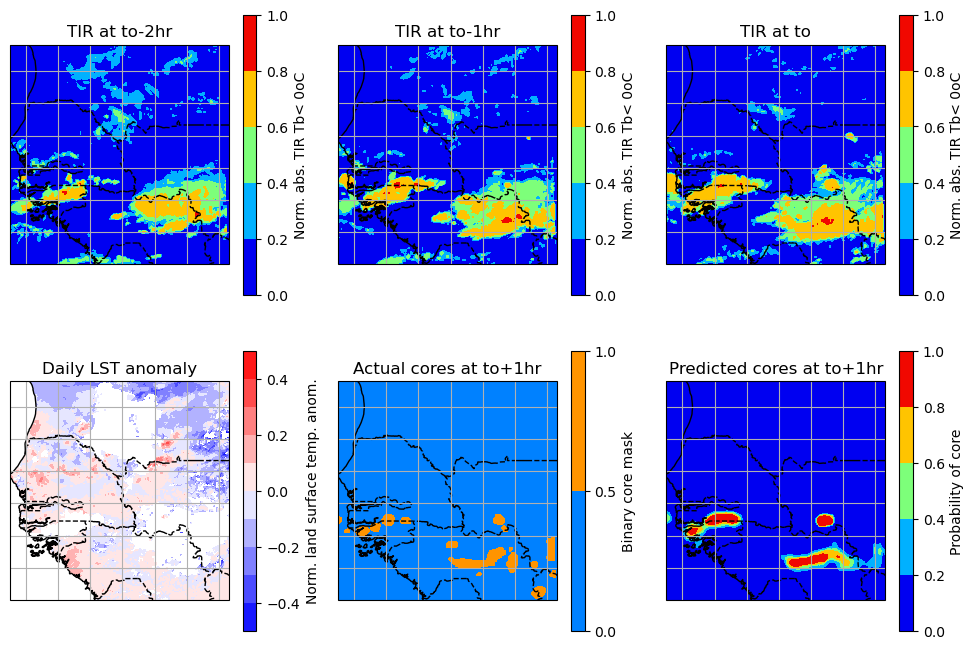

In [24]:
data = np.zeros((6,image_height,image_width))
data[0] = np.squeeze(frames[:,:,0])
data[1] = np.squeeze(frames[:,:,1])
data[2] = np.squeeze(frames[:,:,2])
lst_plt = np.squeeze(frames[:,:,3])
lst_plt[np.where(frames[:,:,4]<0.5)]=np.nan
data[3] = lst_plt
data[4] = np.squeeze(original_frame[:,:])
data[5] = np.squeeze(predicted_frame[0,:,:,0])
titles = ['TIR at to-2hr','TIR at to-1hr','TIR at to','Daily LST anomaly','Actual cores at to+1hr', 'Predicted cores at to+1hr']
levels_custom=[[0, 0.2, 0.4, 0.6, 0.8,1],np.arange(-0.5,0.55,0.1),np.arange(0,1.05,0.2),[0, 0.5, 1]]
labels=['Norm. abs. TIR Tb< 0oC','Norm. land surface temp. anom.','Binary LSTA data mask','Binary core mask','Probability of core']

fig, axes = plt.subplots(2, 3, figsize=(12, 8),subplot_kw={'projection':ccrs.PlateCarree()})
#axes[1][2].set_visible(False)

for idx, ax in enumerate(axes[0]):
    plot_maps_colorbar(ax, reg_lon[b:], reg_lat[:-a], data[idx],  title=None ,levels_custom= levels_custom[0],clabel=labels[0],cmap='jet')
    ax.set_title(titles[idx])
    ax.set_xlim(reg_lon[b],reg_lon[-1])
    ax.set_ylim(reg_lat[0],reg_lat[-a])
    #ax.axis("off")

for idx, ax in enumerate(axes[1]):
    if idx==0:
        plot_maps_colorbar(ax, reg_lon[b:], reg_lat[:-a], data[idx+3],  title=None ,levels_custom= levels_custom[1],clabel=labels[1],cmap='bwr')
        ax.set_title(titles[idx+3])
        ax.set_xlim(reg_lon[b],reg_lon[-1])
    if idx==1:
        plot_maps_colorbar(ax, reg_lon[b:], reg_lat[:-a], data[idx+3],  title=None ,levels_custom= levels_custom[3],clabel=labels[3],cmap='jet')
        ax.set_title(titles[idx+3])
        ax.set_xlim(reg_lon[b],reg_lon[-1])
    if idx==2:        
        plot_maps_colorbar(ax, reg_lon[b:], reg_lat[:-a], data[idx+3],  title=None ,levels_custom= levels_custom[0],clabel=labels[4],cmap='jet')        
        ax.set_title(titles[idx+3])
        ax.set_xlim(reg_lon[b],reg_lon[-1])
        
    #ax.axis("off")
    

# Print information and display the figure.
#print('Predicting core at 1hr')
print(time_test[batch_number])
plt.show()

In [25]:
#frames= np.zeros((image_height,image_width, num_channels))
#predicted_frames= np.zeros((x_test.shape[0],image_height,image_width))

#for i in range(0,x_test.shape[0],1):
    #batch_number = 10 # 0,1
    #frames[:,:,:] = x_test[i,:,:,:] # 
    #original_frame[i,:,:] = y_test[i,:,:] # 
    
    # Extract the model's prediction and post-process it.
#predicted_frames[i,:,:] = np.squeeze(unet_model.predict(np.expand_dims(frames, axis=0)))
predicted_frames= np.squeeze(unet_model.predict([x_test,time_of_day_test]))
    
    

/home/jawahm/miniforge3/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-11-30 21:41:30.259965: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2335703040 exceeds 10% of free system memory.


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step


In [42]:
fpr, tpr, thresholds = metrics.roc_curve(y_test.flatten(), predicted_frames.flatten())

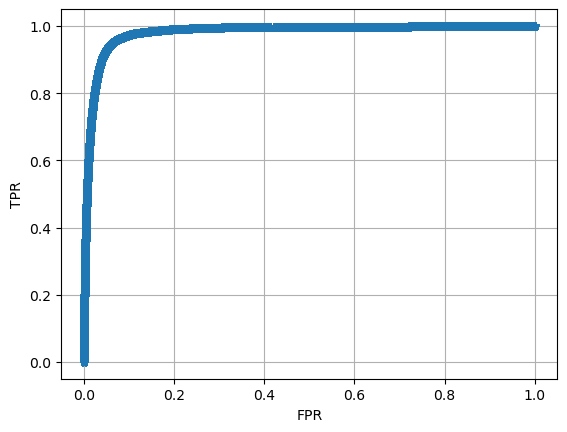

In [43]:
# Create a line plot
plt.plot(fpr, tpr,linestyle='-',marker="*")
plt.xlabel('FPR')
plt.ylabel('TPR')
# Show the plot
plt.grid()
plt.show()

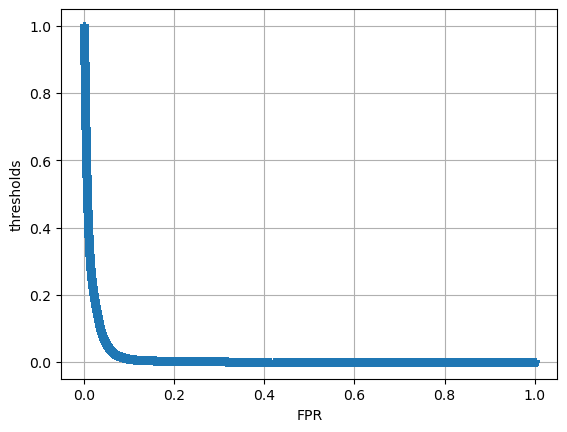

In [44]:
# Create a line plot
plt.plot(fpr, thresholds,linestyle='-',marker="*")
#plt.text(0.7, 0.2, 'threshold=0.03', fontsize = 12)
plt.xlabel('FPR')
plt.ylabel('thresholds')
# Show the plot
plt.grid()
plt.show()

In [45]:
core_prob_threshold = 0.1
y_pred = np.zeros((x_test.shape[0],image_height,image_width))
ind_okay = np.where(predicted_frames>core_prob_threshold)
y_pred[ind_okay] = 1


In [46]:
# 0.03
tn, fp, fn, tp= confusion_matrix(y_test.flatten(), y_pred.flatten()).ravel()
print(tn, fp, fn, tp)

37080135 1362182 59053 427014


In [47]:
a=(tn, fp, fn, tp)
print(a/(tn+ fp+ fn+ tp))

[0.95252182 0.034992   0.00151697 0.01096922]


In [26]:
def FSS_accuracy_metric(target_tensor, prediction_tensor,half_window_size_px):
    
    half_window_size_px=half_window_size_px #2
    use_as_loss_function=False 
    #mask_matrix
    test_mode=False
    """Fractions skill score (FSS).

    M = number of rows in grid
    N = number of columns in grid

    :param half_window_size_px: Number of pixels (grid cells) in half of
        smoothing window (on either side of center).  If this argument is K, the
        window size will be (1 + 2 * K) by (1 + 2 * K).
    :param use_as_loss_function: Boolean flag.  FSS is positively oriented
        (higher is better), but if using it as loss function, we want it to be
        negatively oriented.  Thus, if `use_as_loss_function == True`, will
        return 1 - FSS.  If `use_as_loss_function == False`, will return just
        FSS.
    :param mask_matrix: M-by-N numpy array of Boolean flags.  Grid cells marked
        "False" are masked out and not used to compute the loss.
    :param function_name: Function name (string).
    :param test_mode: Leave this alone.
    :return: loss: Loss function (defined below).
    """

    weight_matrix = _create_mean_filter(
        half_num_rows=half_window_size_px,
        half_num_columns=half_window_size_px, num_channels=1
    )
              
    """Computes loss (fractions skill score).

        :param target_tensor: Tensor of target (actual) values.
        :param prediction_tensor: Tensor of predicted values.
        :return: loss: Fractions skill score.
    """

    smoothed_target_tensor = K.conv2d(
        x=target_tensor, kernel=weight_matrix,
        padding='same', strides=(1, 1), data_format='channels_last'
    )

    smoothed_prediction_tensor = K.conv2d(
        x=prediction_tensor, kernel=weight_matrix,
        padding='same', strides=(1, 1), data_format='channels_last'
    )

    #smoothed_target_tensor = smoothed_target_tensor * eroded_mask_matrix
    #smoothed_prediction_tensor = smoothed_prediction_tensor * eroded_mask_matrix)

    actual_mse = K.mean(
        (smoothed_target_tensor - smoothed_prediction_tensor) ** 2
    )
    reference_mse = K.mean(
        smoothed_target_tensor ** 2 + smoothed_prediction_tensor ** 2
    )

    if use_as_loss_function:
        return actual_mse / reference_mse

    return 1. - actual_mse / reference_mse



In [29]:
y_test1= tf.expand_dims(y_test, axis=3)
y_test1= tf.cast(y_test1, tf.float32)
ffs_array=[]
prob_threshold=[]

for core_prob_threshold in range(0,11,1):
    y_pred = np.zeros((x_test.shape[0],image_height,image_width))
    ind_okay = np.where(predicted_frames>core_prob_threshold/10)
    y_pred[ind_okay] = 1
    y_pred1 = tf.expand_dims(y_pred, axis=3)
    y_pred1 = tf.cast(y_pred1, tf.float32)
    FSS_Score = FSS_accuracy_metric(y_test1, y_pred1,7)
    print(FSS_Score)
    ffs_array.append(FSS_Score) 
    prob_threshold.append(core_prob_threshold/10)
    
    
#with open('../pkl_files/Prob_threshold_vs_Eval_FSS_scores_reg_grid_3channel_1hr_using_1hr_TIR_TOD_LST.pkl', 'wb') as file: 
   # pickle.dump([prob_threshold,ffs_array], file) 
 

tf.Tensor(0.02386278, shape=(), dtype=float32)
tf.Tensor(0.55377895, shape=(), dtype=float32)
tf.Tensor(0.65582156, shape=(), dtype=float32)
tf.Tensor(0.7136617, shape=(), dtype=float32)
tf.Tensor(0.7373974, shape=(), dtype=float32)
tf.Tensor(0.73910034, shape=(), dtype=float32)
tf.Tensor(0.7149602, shape=(), dtype=float32)
tf.Tensor(0.6601515, shape=(), dtype=float32)
tf.Tensor(0.5947158, shape=(), dtype=float32)
tf.Tensor(0.53848994, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


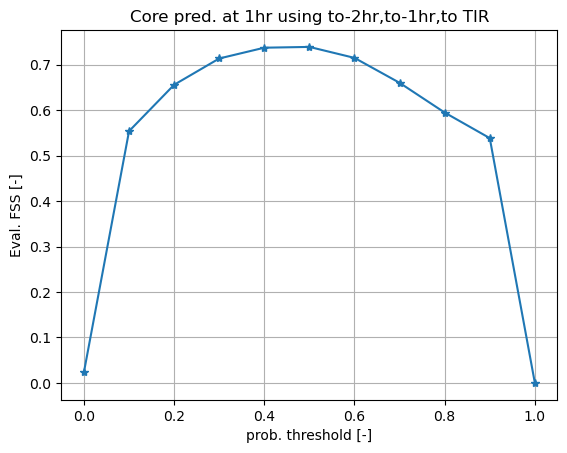

In [30]:
plt.plot(prob_threshold, ffs_array, linestyle='-',marker="*")
plt.xlabel('prob. threshold [-]')
plt.ylabel('Eval. FSS [-]')
# Show the plot
plt.title('Core pred. at 1hr using to-2hr,to-1hr,to TIR')
plt.grid()
plt.show()

In [ ]:
y_test1= tf.expand_dims(y_test, axis=3)
y_test1= tf.cast(y_test1, tf.float32)
#[max_ffs, indx] = np.nax(ffs_array)
core_prob_threshold=0.3
y_pred = np.zeros((x_test.shape[0],image_height,image_width))
ind_okay = np.where(predicted_frames>core_prob_threshold)
y_pred[ind_okay] = 1
y_pred1 = tf.expand_dims(y_pred, axis=3)
y_pred1 = tf.cast(y_pred1, tf.float32)
half_window_size=[1, 2, 5, 7, 10, 13, 20, 30]
ffs_array = []
FSS_eval_kernel=[]

for FFS_kernal_size in half_window_size:
    FSS_Score = FSS_accuracy_metric(y_test1, y_pred1,FFS_kernal_size)
    print(FSS_Score)
    ffs_array.append(FSS_Score) 
    FSS_eval_kernel.append(FFS_kernal_size*2+1)
    
       

tf.Tensor(0.55923766, shape=(), dtype=float32)
tf.Tensor(0.5945504, shape=(), dtype=float32)
tf.Tensor(0.6759975, shape=(), dtype=float32)


In [ ]:
plt.plot(FSS_eval_kernel, ffs_array, linestyle='-',marker="*")
plt.xlabel('Eval. FSS filter [# of pixels x # of pixels]')
plt.ylabel('Eval. FSS [-]')
# Show the plot
plt.title('Core pred. at 1hr using to-2hr,to-1hr,to TIR')
plt.grid()
plt.show()

In [ ]:
with open('../pkl_files/Eval_FSS_scores_3channel_1hr_using_1hr_TIR_TOD_LST.pkl', 'wb') as file: 
    pickle.dump([FSS_eval_kernel,ffs_array], file) 
 